
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [40]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [41]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()

import operator

import statsmodels.api as sm


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.


**1.3** Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.

Plot two histograms ofyour best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.

Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.


**1.4** Using your top gene from the previous part (call it  `best_predictor`), create a classification model by manually eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.

<hr> <hr>

<hr>
### Solutions

**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [42]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)


X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [43]:
print(df.shape)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))


(752, 7130)
(601, 7129) (151, 7129) (601,) (151,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.**


In [44]:
X_train.head() #take a peek at training set
X_train.describe() #main stats of training set


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,-115.860969,-160.846155,26.545301,209.733439,-248.992903,-405.422569,-24.135140,-188.491329,74.777098,97.436777,...,161.766492,707.377318,4.198787,421.466477,-50.023954,819.053113,329.803212,8.803791,507.250039,-24.377549
std,170.571929,188.676919,207.781982,202.987246,207.328054,261.112412,535.143398,163.077167,174.693115,358.897719,...,165.152970,526.644408,152.401188,589.914084,106.864078,814.898058,367.788891,85.397644,939.394188,71.102874
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-501.285884,-1010.430536,-447.077819,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-222.586579,-270.502055,-95.000000,85.327810,-379.048622,-567.547758,-338.435164,-302.872287,-20.739507,-117.000000,...,67.861184,361.596510,-88.660905,88.409441,-105.000000,270.198265,90.825501,-40.391630,-50.785999,-73.000000
50%,-105.139096,-145.829450,21.183690,207.291048,-231.007621,-433.214742,-39.581881,-175.586059,90.170754,101.975176,...,153.253301,679.935520,9.960900,381.000000,-35.000000,749.281111,296.978609,7.968505,407.942117,-25.403427
75%,-4.789696,-40.599329,127.821586,331.277808,-116.000000,-252.587379,325.000000,-74.379003,190.551199,288.503617,...,263.112797,1076.075567,96.051876,720.339588,19.775025,1286.343005,521.096719,62.794411,1092.430279,19.740635
max,516.618491,384.626762,748.233182,1022.560525,308.876677,607.737258,1385.881293,263.634029,589.778466,1355.537180,...,686.321597,2522.188808,481.820516,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3315.374276,224.773440


In [45]:
#normalize each predictor to vary between 0 and 1
scaler = MinMaxScaler(copy=False, feature_range=(0, 1))
scaler.fit_transform(X_train)
scaler.fit_transform(X_test)
X_train.head()
X_train_normal = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train_normal.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.574689,0.652904,0.528552,0.202384,0.504132,0.309107,0.439480,0.524446,0.723161,0.411162,...,0.516278,0.391074,0.752595,0.484137,0.683508,0.389115,0.413169,0.562775,0.538180,0.524258
1,0.587407,0.535608,0.249427,0.171417,0.752874,0.513878,0.655342,0.464181,0.324602,0.559483,...,0.635019,0.317177,0.700050,0.336964,0.454571,0.406687,0.339430,0.452814,0.388218,0.380795
2,0.446787,0.630576,0.554963,0.413946,0.662329,0.665892,0.145850,0.648430,0.478307,0.551411,...,0.439609,0.233910,0.235984,0.343672,0.733797,0.369846,0.323172,0.500478,0.457391,0.556345
3,0.568391,0.666018,0.735454,0.564376,0.662796,0.302675,0.513584,0.359108,0.706408,0.272227,...,0.574234,0.449615,0.426995,0.390941,0.650875,0.615891,0.251946,0.695112,0.436069,0.458655
4,0.532581,0.834889,0.357527,0.447480,0.631015,0.198841,0.678084,0.515280,0.487490,0.440010,...,0.539831,0.543511,0.528163,0.442338,0.578272,0.404435,0.531047,0.372191,0.751796,0.469227


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.**

The problem when p (predictors) > n (observations) in a classification model is that there is no unique solution that fits the data and some predictors may have little to no influence on the predicted result. It may also result in overfitting to the training set.


**1.3** **Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.**

**Plot two histograms of your best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.**

In [46]:
##identify and report which 10 genes individually discriminate between the two cancer classes the best

#join the Cancer_type column (y_train) to the normalized X_train dataset
normalized_df_train = X_train.join(y_train)
normalized_df_train.head()

#split dataset into Class ALL ie. Cancer_type = 0 and Class AML ie. Cancer_type = 1
df_cancer_type_all = normalized_df_train[normalized_df_train['Cancer_type'] == 0]
df_cancer_type_all = df_cancer_type_all.drop(columns = ['Cancer_type'])
df_cancer_type_aml = normalized_df_train[normalized_df_train['Cancer_type'] == 1]
df_cancer_type_aml = df_cancer_type_aml.drop(columns = ['Cancer_type'])

#initialize t-stat dictionary
t_stat_results = {}

for col in df_cancer_type_all:
    #calculate mean, std, and n for each feature/gene in class ALL
    mean_all = df_cancer_type_all[col].mean()
    std_all = df_cancer_type_all[col].std()
    count_all = df_cancer_type_all[col].count()
    
    #calculate mean, std, and n for each feature/gene in class AML
    mean_aml = df_cancer_type_aml[col].mean()
    std_aml = df_cancer_type_aml[col].std()
    count_aml = df_cancer_type_aml[col].count()
    
    #calculate t-statistic for each feature/gene
    t_num = abs(mean_all - mean_aml)
    t_denom = np.sqrt( (std_all ** 2) / count_all + (std_aml ** 2) / count_aml)
    t_stat = t_num / t_denom 
    t_stat_results[col] = t_stat

sorted_t_stat_results = sorted(t_stat_results.items(), key=operator.itemgetter(1), reverse=True)


In [47]:
#top ten genes predicting class ALL and class AML
top_ten_genes = sorted_t_stat_results[0:10]

gene_names = []
for gene in top_ten_genes:
    name = gene[0]
    gene_names.append(name)
print(gene_names)

['M31523_at', 'X95735_at', 'M84526_at', 'X61587_at', 'U50136_rna1_at', 'X17042_at', 'U29175_at', 'Y08612_at', 'Z11793_at', 'X76648_at']


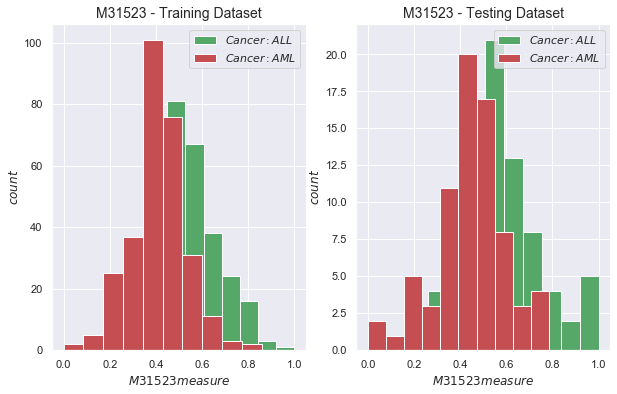

In [48]:
##plot histograms for best predictor M31523_at w/ t-stat = 12.537397241580127
n_bins = 10;

fig, axs = plt.subplots(1, 2, figsize=(10, 6));

#plot training data histogram
axs[0].hist(df_cancer_type_all['M31523_at'], bins=n_bins);
axs[0].hist(df_cancer_type_aml['M31523_at'], bins=n_bins);
axs[0].hist(df_cancer_type_all['M31523_at'], bins=n_bins, label='$Cancer : ALL$');
axs[0].hist(df_cancer_type_aml['M31523_at'], bins=n_bins, label='$Cancer : AML$');
axs[0].set_xlabel('$M31523 measure$')
axs[0].set_ylabel('$count$')
axs[0].set_title('M31523 - Training Dataset', fontsize=14)
axs[0].legend(loc='best');

#repeat normalization and data split from before for testing data
normalized_df_test = X_test.join(y_test)
df_cancer_type_all_test = normalized_df_test[normalized_df_test['Cancer_type'] == 0]
df_cancer_type_all_test = df_cancer_type_all_test.drop(columns = ['Cancer_type'])
df_cancer_type_aml_test = normalized_df_test[normalized_df_test['Cancer_type'] == 1]
df_cancer_type_aml_test = df_cancer_type_aml_test.drop(columns = ['Cancer_type'])

#plot testing data histogram
axs[1].hist(df_cancer_type_all_test['M31523_at'], bins=n_bins);
axs[1].hist(df_cancer_type_aml_test['M31523_at'], bins=n_bins);
axs[1].hist(df_cancer_type_all_test['M31523_at'], bins=n_bins, label='$Cancer : ALL$');
axs[1].hist(df_cancer_type_aml_test['M31523_at'], bins=n_bins, label='$Cancer : AML$');
axs[1].set_xlabel('$M31523 measure$')
axs[1].set_ylabel('$count$')
axs[1].set_title('M31523 - Testing Dataset', fontsize=14)
axs[1].legend(loc='best');

**1.4 Using your top gene from the previous part (call it  `best_predictor`), create a classification model by eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.**


In [49]:
#your code here
best_predictor = gene_names[0] #'M31523_at' from previous question

#estimate value that would descriminate the best by getting middle point between means of two distributions
#Rational is that the Cancer_type is more likely to be ALL if the gene/predictor value is higher than the middle point of the two distribution means and the reverse for AML.
mean_all = df_cancer_type_all['M31523_at'].mean()
mean_aml = df_cancer_type_aml['M31523_at'].mean()
est_value = (mean_all + mean_aml)/2 # this is our estimated value

#initialize prediction array
y_eye_ball_pred_train = []
y_eye_ball_pred_test = []

#loop through training dataframe and categorize in two classes depending on where best predictor value falls wrt to estimated value
for item in X_train[best_predictor].iteritems():
    if item[1] <= est_value:
        y_eye_ball_pred_train.append(1) #AML
    elif item[1] >= est_value:
        y_eye_ball_pred_train.append(0) #ALL
        
#loop through testing dataframe and categorize in two classes depending on where best predictor value falls wrt to estimated value
for item in X_test[best_predictor].iteritems():
    if item[1] <= est_value:
        y_eye_ball_pred_test.append(1) #AML
    elif item[1] >= est_value:
        y_eye_ball_pred_test.append(0) #ALL

#accuracy testing
accurate_predictions = []
accurate_pred_count = 0

for i, pred in enumerate(y_eye_ball_pred_test):
    if pred == int(y_test.iloc[i]):
        accurate_predictions.append(True)
        accurate_pred_count += 1
    elif pred != int(y_test.iloc[i]):
        accurate_predictions.append(False)

total_pred_count = len(accurate_predictions)
accuracy_score = accurate_pred_count / total_pred_count
print("The accuracy score on the testing set is: {}".format(accuracy_score))

The accuracy score on the testing set is: 0.6887417218543046


<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>


In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor that you identify as the best predictor above to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?


Create a figure with following items displayed on the same plot (use training data):
 - the predicted quantitative response from the linear regression model as a function of the best gene predictor
 - the true binary response. 


**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret the logistic regression coefficients: the 'slope' and intercept. 


Create 2 plots (one each for training and testing data) with 4 items displayed on each plot.
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



<hr>
### Solutions

**2.1** **Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML).  Is there a problem with this interpretation?**



In [50]:
# your code here
#only use best predictor to fit the model
best_predictor = 'M31523_at'
X_train_best_pred = X_train[[best_predictor]]
X_test_best_pred = X_test[[best_predictor]]

#linear regression model
model_linear = LinearRegression()


#fitting
model_linear.fit(X_train_best_pred, y_train)


#predicting
y_pred_train = model_linear.predict(X_train_best_pred)
y_pred_test = model_linear.predict(X_test_best_pred)

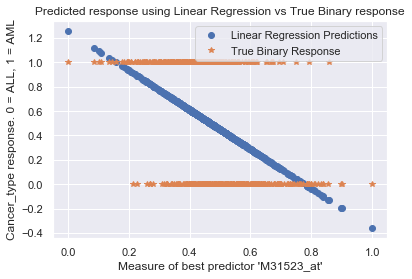

In [51]:
# your code here

#plot
plt.plot(X_train_best_pred, y_pred_train, 'o', label ='Linear Regression Predictions')
plt.plot(X_train_best_pred, y_train, '*', label ='True Binary Response')
plt.title("Predicted response using Linear Regression vs True Binary response")
plt.xlabel("Measure of best predictor 'M31523_at'")
plt.ylabel("Cancer_type response. 0 = ALL, 1 = AML")
plt.legend()

Yes, there is a problem with this interpretation because as we can see in the graph, the linear model is a poor predictor of categorical data. Essentially, every point above 0.5 would be rounded to 1 and every point below would be rounded to 0. Especially in a high-stakes scenario like this one ie. predicting cancer type, we should build a model that does a better job at predicting the categorical outcome.


**2.2** **Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.**

In [52]:
# your code here
# Bayes classifier: if > 0.5 = 1, else = 0.

y_bayes_pred_train = []
y_bayes_pred_test = []

#training set
for item in y_pred_train:
    if item <= 0.5:
        y_bayes_pred_train.append(0)
    elif item >= 0.5:
        y_bayes_pred_train.append(1)
        
#testing set
for item in y_pred_test:
    if item <= 0.5:
        y_bayes_pred_test.append(0)
    elif item >= 0.5:
        y_bayes_pred_test.append(1)
        
#accuracy test - training set
accurate_predictions_train = []
accurate_pred_count_train = 0

for i, pred in enumerate(y_bayes_pred_train):
    if pred == int(y_train.iloc[i]):
        accurate_predictions_train.append(True)
        accurate_pred_count_train += 1
    elif pred != int(y_train.iloc[i]):
        accurate_predictions_train.append(False)

total_pred_count_train = len(accurate_predictions_train)
accuracy_score_train = accurate_pred_count_train / total_pred_count_train
print("The accuracy score on the training set is: {}".format(accuracy_score_train))

#accuracy test - testing set
accurate_predictions_test = []
accurate_pred_count_test = 0

for i, pred in enumerate(y_bayes_pred_test):
    if pred == int(y_test.iloc[i]):
        accurate_predictions_test.append(True)
        accurate_pred_count_test += 1
    elif pred != int(y_test.iloc[i]):
        accurate_predictions_test.append(False)

total_pred_count_test = len(accurate_predictions_test)
accuracy_score_test = accurate_pred_count_test / total_pred_count_test
print("The accuracy score on the testing set is: {}".format(accuracy_score_test))


The accuracy score on the training set is: 0.7088186356073212
The accuracy score on the testing set is: 0.6821192052980133



**2.3** **Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Are the classifications substantially different?  Explain why this is the case.**

**Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

In [53]:
# your code here
#Training
model_logistic = LogisticRegression(C=100000).fit(X_train[[best_predictor]], y_train)

#Predict
y_pred_logistic_train = model_logistic.predict_proba(X_train[[best_predictor]])[:,1]
y_pred_logistic_test = model_logistic.predict_proba(X_test[[best_predictor]])[:,1]

# Bayes classifier: if > 0.5 = 1, else = 0.

y_bayes_pred_train = []
y_bayes_pred_test = []

#training set
for item in y_pred_logistic_train:
    if item <= 0.5:
        y_bayes_pred_train.append(0)
    elif item >= 0.5:
        y_bayes_pred_train.append(1)
        
#testing set
for item in y_pred_logistic_test:
    if item <= 0.5:
        y_bayes_pred_test.append(0)
    elif item >= 0.5:
        y_bayes_pred_test.append(1)
        
#accuracy test - training set
accurate_predictions_train = []
accurate_pred_count_train = 0

for i, pred in enumerate(y_bayes_pred_train):
    if pred == int(y_train.iloc[i]):
        accurate_predictions_train.append(True)
        accurate_pred_count_train += 1
    elif pred != int(y_train.iloc[i]):
        accurate_predictions_train.append(False)

total_pred_count_train = len(accurate_predictions_train)
accuracy_score_train = accurate_pred_count_train / total_pred_count_train
print("The accuracy score on the training set is: {}".format(accuracy_score_train))

#accuracy test - testing set
accurate_predictions_test = []
accurate_pred_count_test = 0

for i, pred in enumerate(y_bayes_pred_test):
    if pred == int(y_test.iloc[i]):
        accurate_predictions_test.append(True)
        accurate_pred_count_test += 1
    elif pred != int(y_test.iloc[i]):
        accurate_predictions_test.append(False)

total_pred_count_test = len(accurate_predictions_test)
accuracy_score_test = accurate_pred_count_test / total_pred_count_test
print("The accuracy score on the testing set is: {}".format(accuracy_score_test))

The accuracy score on the training set is: 0.7071547420965059
The accuracy score on the testing set is: 0.6688741721854304


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The training and testing accuracies are not significantly different compared to the linear regression model. This is because we always round up if value of predictor is above 0.5 and round down otherwise, so the shape of the line doesn't make much of a difference.


**2.4 Print and interpret the logistic regression coefficients: the 'slope' and the intercept.**

**Create 2 plots (with training and test data) with 4 items displayed on each plot.**
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$.

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.** 


In [54]:
# your code here
#print coefs and intercept
print("Slope is: {}".format(model_logistic.coef_[0]))
print("Intercept is: {}".format(model_logistic.intercept_ ))

Slope is: [-8.75710451]
Intercept is: [4.07726908]


Text(0, 0.5, 'Cancer_type response')

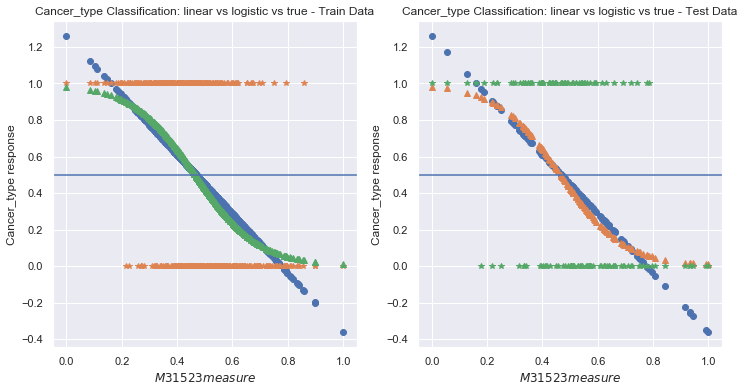

In [55]:
# your code here
fig, axs = plt.subplots(1, 2, figsize=(12, 6));

axs[0].plot(X_train_best_pred, y_pred_train, 'o', label ='Linear Regression Predictions')
axs[0].plot(X_train_best_pred, y_train, '*', label ='True Binary Response')
axs[0].plot(X_train_best_pred, y_pred_logistic_train, '^', label ='Logistic Response')
axs[0].axhline(y = 0.5)
axs[0].set_title('Cancer_type Classification: linear vs logistic vs true - Train Data')
axs[0].set_xlabel('$M31523 measure$')
axs[0].set_ylabel("Cancer_type response")


axs[1].plot(X_test_best_pred, y_pred_test, 'o', label ='Linear Regression Predictions')
axs[1].plot(X_test_best_pred, y_pred_logistic_test, '^', label ='Logistic Response')
axs[1].plot(X_test_best_pred, y_test, '*', label ='True Binary Response')
axs[1].axhline(y = 0.5)
axs[1].set_title('Cancer_type Classification: linear vs logistic vs true - Test Data')
axs[1].set_xlabel('$M31523 measure$')
axs[1].set_ylabel("Cancer_type response")


Both linear and logistic models show more or less the same accuracy scores so it doesn't appear like one is much better than the other. Linear is very slightly better.

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of training and test set? Given the results above how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole? 

**3.4** Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

<hr>
### Solutions

**3.1** **Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [56]:
# your code here

#create model
model_multi_logistic = LogisticRegression(C=100000).fit(X_train, y_train)

#Predict
y_pred_multi_logistic_train = model_multi_logistic.predict_proba(X_train)[:,1]
y_pred_multi_logistic_test = model_multi_logistic.predict_proba(X_test)[:,1]

# Bayes classifier: if > 0.5 = 1, else = 0.

y_bayes_pred_train = []
y_bayes_pred_test = []

#training set
for item in y_pred_multi_logistic_train:
    if item <= 0.5:
        y_bayes_pred_train.append(0)
    elif item >= 0.5:
        y_bayes_pred_train.append(1)
        
#testing set
for item in y_pred_multi_logistic_test:
    if item <= 0.5:
        y_bayes_pred_test.append(0)
    elif item >= 0.5:
        y_bayes_pred_test.append(1)
        
#accuracy test - training set
accurate_predictions_train = []
accurate_pred_count_train = 0

for i, pred in enumerate(y_bayes_pred_train):
    if pred == int(y_train.iloc[i]):
        accurate_predictions_train.append(True)
        accurate_pred_count_train += 1
    elif pred != int(y_train.iloc[i]):
        accurate_predictions_train.append(False)

total_pred_count_train = len(accurate_predictions_train)
accuracy_score_train = accurate_pred_count_train / total_pred_count_train
print("The accuracy score on the training set is: {}".format(accuracy_score_train))

#accuracy test - testing set
accurate_predictions_test = []
accurate_pred_count_test = 0

for i, pred in enumerate(y_bayes_pred_test):
    if pred == int(y_test.iloc[i]):
        accurate_predictions_test.append(True)
        accurate_pred_count_test += 1
    elif pred != int(y_test.iloc[i]):
        accurate_predictions_test.append(False)

total_pred_count_test = len(accurate_predictions_test)
accuracy_score_test = accurate_pred_count_test / total_pred_count_test
print("The accuracy score on the testing set is: {}".format(accuracy_score_test))

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy score on the training set is: 1.0
The accuracy score on the testing set is: 0.7615894039735099


The accuracy scores of the multiple logistic regression model are much better than the model fitted in question 2 (1 on training and 0.76 on testing dataset). So, adding in other genes does make a difference in the predictions.


In [57]:
X_train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,0.574689,0.652904,0.528552,0.202384,0.504132,0.309107,0.439480,0.524446,0.723161,0.411162,...,0.516278,0.391074,0.752595,0.484137,0.683508,0.389115,0.413169,0.562775,0.538180,0.524258
604,0.587407,0.535608,0.249427,0.171417,0.752874,0.513878,0.655342,0.464181,0.324602,0.559483,...,0.635019,0.317177,0.700050,0.336964,0.454571,0.406687,0.339430,0.452814,0.388218,0.380795
341,0.446787,0.630576,0.554963,0.413946,0.662329,0.665892,0.145850,0.648430,0.478307,0.551411,...,0.439609,0.233910,0.235984,0.343672,0.733797,0.369846,0.323172,0.500478,0.457391,0.556345
117,0.568391,0.666018,0.735454,0.564376,0.662796,0.302675,0.513584,0.359108,0.706408,0.272227,...,0.574234,0.449615,0.426995,0.390941,0.650875,0.615891,0.251946,0.695112,0.436069,0.458655
516,0.532581,0.834889,0.357527,0.447480,0.631015,0.198841,0.678084,0.515280,0.487490,0.440010,...,0.539831,0.543511,0.528163,0.442338,0.578272,0.404435,0.531047,0.372191,0.751796,0.469227


**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** **To answer this question, use *bootstrapping* with 1000 bootstrap samples/iterations.**  


In [58]:
bootstrap_coefs_all = []

def bootstrap(X, y, sample_size): 
    
    #get 100 samples per iteration
    X_bootstrap_sample = X.sample(n = sample_size, replace = True)
    y_bootstrap_sample = y.iloc[X_bootstrap_sample.index]

    #build logistic regression model
    bootstrap_logistic_model = LogisticRegression(C=100000, solver = "lbfgs").fit(X_bootstrap_sample, y_bootstrap_sample)
    
    #get coefficients
    bootstrap_coefs = bootstrap_logistic_model.coef_[0]
    
    return bootstrap_coefs
    

def ttest(coef_array):
    #initialize t-score array
    t_scores = []
    
    #transform coef array into dataframe
    coefs_all_pd = pd.DataFrame(coef_array, columns = X_train_normal.columns)
    
    #calc t-scores for each column of dataframe
    for col in coefs_all_pd.columns:
        t_score = abs(np.mean(coefs_all_pd[col]))/(np.sqrt((np.std(coefs_all_pd[col])**2)/100))
        t_scores.append(t_score)
    return t_scores

def count_sig_coefs(t_score_array):
    sig_count = 0
    for score in t_score_array:
        if score > 1.96: #1.96 t_score for 5% significance
            sig_count += 1
    return sig_count

#create bootstrap
for i in range(0,99): #100 iterations of sampling
    bootstrap_coefs_all.append(bootstrap(X_train_normal, y_train, 100))

#run t-test on it
ttest_on_bootstrap = ttest(bootstrap_coefs_all)

#count significant coefficients
sig_coef_count = count_sig_coefs(ttest_on_bootstrap)
print("Number of significant genes in dataset: {}".format(sig_coef_count))

Number of significant genes in dataset: 5685


In [59]:
# your code here


**3.3 Open question: Comment on the classification accuracy of training and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole.**

The accuracy of the model on the training set was 1 and the testing set was around 0.76. Given that our model is perfectly fitted to the training set, I would be concerned that we are overfitting to the training data and that our model is not generalizable enough. I would recommend regularization and cross validation as a way to overcome this problem.

**3.4 Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.**

In [60]:
# your code here
multi_logistic_reg = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear').fit(X_train_normal, y_train)

#predict
y_pred_reg_train = multi_logistic_reg.predict(X_train)
y_pred_reg_test = multi_logistic_reg.predict(X_test)


#accuracy test - training set
accurate_predictions_train = []
accurate_pred_count_train = 0

for i, pred in enumerate(y_pred_reg_train):
    if pred == int(y_train.iloc[i]):
        accurate_predictions_train.append(True)
        accurate_pred_count_train += 1
    elif pred != int(y_train.iloc[i]):
        accurate_predictions_train.append(False)

total_pred_count_train = len(accurate_predictions_train)
accuracy_score_train = accurate_pred_count_train / total_pred_count_train
print("The accuracy score on the training set is: {}".format(accuracy_score_train))

#accuracy test - testing set
accurate_predictions_test = []
accurate_pred_count_test = 0

for i, pred in enumerate(y_pred_reg_test):
    if pred == int(y_test.iloc[i]):
        accurate_predictions_test.append(True)
        accurate_pred_count_test += 1
    elif pred != int(y_test.iloc[i]):
        accurate_predictions_test.append(False)

total_pred_count_test = len(accurate_predictions_test)
accuracy_score_test = accurate_pred_count_test / total_pred_count_test
print("The accuracy score on the testing set is: {}".format(accuracy_score_test))

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The accuracy score on the training set is: 0.9101497504159733
The accuracy score on the testing set is: 0.8211920529801324


**3.5: Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [61]:
# your code here
coefficients_reg = pd.DataFrame (multi_logistic_reg.coef_, columns = X_train_normal.columns)

for col in coefficients_reg.columns:
    if coefficients_reg[col][0] != 0 and col in gene_names:
        print(col)

M84526_at
U50136_rna1_at
X61587_at
X95735_at
Z11793_at
M31523_at
U29175_at


In [62]:
# your code here


In [63]:
# your code here


In [64]:
# your code here


The 7 genes that hold up are: 
M84526_at,
U50136_rna1_at,
X61587_at,
X95735_at,
Z11793_at,
M31523_at,
U29175_at

So, not all 10 best predictors stay relevant. This is the case because the LASSO-like regularization factor helps with feature selection and drops the ones that are no longer significant.


<div class='exercise'> <b> Question 4 [25pts]: Multi Class Log Regression </b> </div>

**4.1** Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using the training dataset.  It should be easily discernable via labeling/marking in the plot which observations belong to which `cancer_type`.

**4.3** Fit the following two models using crossvalidation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundaries for each model and interpret the results. Hint: You may utilize the function `overlay_decision_boundary`. 

**4.5** Report and plot the CV scores for the two models and interpret. 


<hr>
### Solutions

**4.1 Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [65]:
#your code here
df = pd.read_csv('~/Documents/CS209a/2019-CS109A/content/homeworks/cs109a_hw4/data/hw4_mc_enhance.csv', index_col=0)

In [66]:
#your code here 
df.groupby('cancer_type').count() # 3 classes of Cancer and 250 instances per class

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
cancer_type,,,,,,,,,,,,,,,,,,,,,
0.0,250,250,250,250,250,250,250,250,250,250,...,250,250,250,250,250,250,250,250,250,250
1.0,250,250,250,250,250,250,250,250,250,250,...,250,250,250,250,250,250,250,250,250,250
2.0,250,250,250,250,250,250,250,250,250,250,...,250,250,250,250,250,250,250,250,250,250


**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [67]:
# your code here
#split dataset
X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'cancer_type'], 
                                                         df.cancer_type, test_size=0.2, 
                                                         random_state = 8, 
                                                         stratify = df.cancer_type)

#normalize training and testing dataset
X_train_normal = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_normal = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

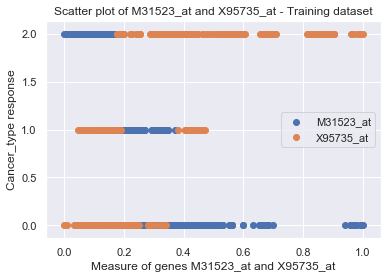

In [68]:
# your code here
X_train_normal_2_genes = X_train_normal[['M31523_at','X95735_at']]

#plot
plt.scatter(X_train_normal[['M31523_at']], y_train, label ='M31523_at')
plt.scatter(X_train_normal[['X95735_at']], y_train, label ='X95735_at') 
plt.title("Scatter plot of M31523_at and X95735_at - Training dataset")
plt.xlabel("Measure of genes M31523_at and X95735_at")
plt.ylabel("Cancer_type response")
plt.legend()

**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [69]:
# your code here
#Fit Logistic Regression Multiclass model with linear features
model_logistic_2_classes = LogisticRegressionCV(multi_class =  'ovr', solver = 'lbfgs').fit(X_train_normal_2_genes, y_train)

#Fit Logistic Regression Multiclass model with Polynomial features, degree = 2
X_train_normal_2_genes_poly = X_train_normal[['M31523_at','X95735_at']]
X_train_normal_2_genes_poly["Polynomial M31523_at"] = X_train_normal_2_genes_poly["M31523_at"] ** 2
X_train_normal_2_genes_poly["Polynomial X95735_at"] = X_train_normal_2_genes_poly["X95735_at"] ** 2

model_logistic_2_classes_poly = LogisticRegressionCV(solver = 'lbfgs').fit(X_train_normal_2_genes_poly, y_train)

# X_train_normal_2_genes_poly.head()

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/l

In [70]:
# your code here


**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [71]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

ValueError: X has 2 features per sample; expecting 4

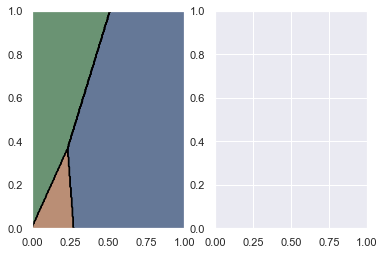

In [72]:
#plot

fig, ax = plt.subplots(1, 2)

overlay_decision_boundary(ax[0], model_logistic_2_classes)
overlay_decision_boundary(ax[1], model_logistic_2_classes_poly)

In [ ]:
# your code here


**4.5 Report and plot the CV scores for the two models and interpret.**

In [73]:
# your code here


In [74]:
# your code here


<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost.  How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the test set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.  Note that this needs to be evaluated on the patients in the test set.**
**
...
**

*your answer here* 


In [75]:
# your code here


**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.**

In order to lower the cost per patient, we need to favor the model making a decision, rather than abstaining since the latter is the main driver of cost. However, the model should still avoid misdiagnosing a patient since that is also costly for the hospital and of course could have terrible consequences for the patient. As a result, we should pick a threashold of certainty that minimizes the overall cost function.